Importing libraries and reading the credit card dataset.

In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve
from tensorflow import keras

import warnings
import os
import tempfile
%matplotlib inline
warnings.filterwarnings('ignore')

# Configuring the plot style and colors for the matplotlib plots.
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Importing the dataset
df = pd.read_csv('creditcard.csv')

Data splitting and scaling.

In [5]:
# Copying the data to the other dataframe.
clean_df = df.copy()

# Drop the columns that are not needed.
clean_df.drop(["Time"], axis=1, inplace=True)

# Changing amount to log amount and dropping the original amount.
eps = 0.001
clean_df['Log Ammount'] = np.log(clean_df.pop('Amount')+eps)


# Splitting the data into train and test sets
train_df, test_df = train_test_split(clean_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

#Np arrays for the labels and the features.
train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [6]:
print(f'Average class probability in training set:   {train_labels.mean():.4f}')
print(f'Average class probability in validation set: {val_labels.mean():.4f}')
print(f'Average class probability in test set:       {test_labels.mean():.4f}')

Average class probability in training set:   0.0018
Average class probability in validation set: 0.0016
Average class probability in test set:       0.0017


In [7]:
stdScaler = StandardScaler()

# Transforming the features
train_features = stdScaler.fit_transform(train_features)
test_features = stdScaler.transform(test_features)
val_features = stdScaler.transform(val_features)

train_features = np.clip(train_features, -5, 5)
test_features = np.clip(test_features, -5, 5)
val_features = np.clip(val_features, -5, 5)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)


Training labels shape: (182276,)
Validation labels shape: (45569,)
Test labels shape: (56962,)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


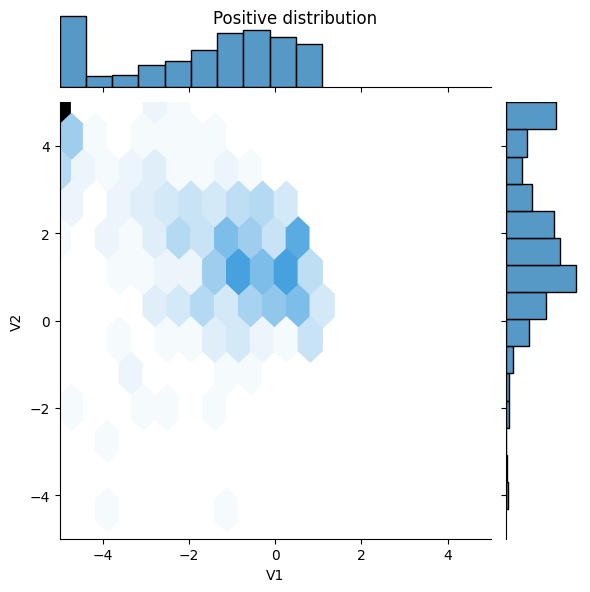

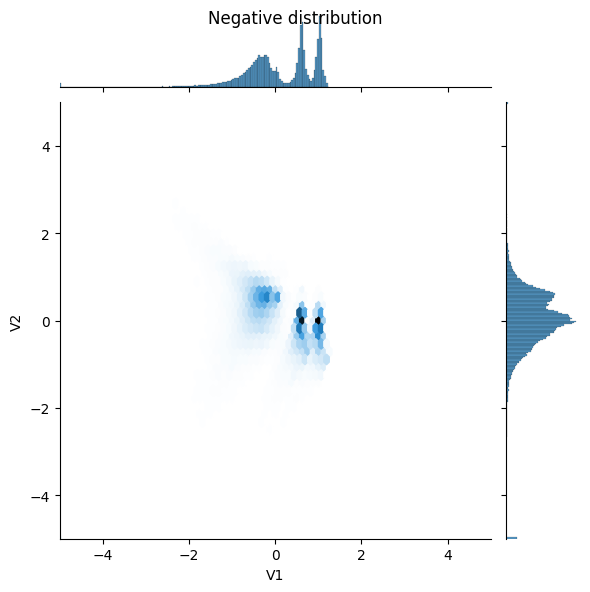

In [8]:
# Comparing positive and negative distributions.
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(x=pos_df['V1'], y=pos_df['V2'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(x=neg_df['V1'], y=neg_df['V2'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

In [9]:
# Metrics for the models.
METRICS = [
    keras.metrics.BinaryCrossentropy(name='cross entropy'),
    keras.metrics.MeanSquaredError(name='Brier score'),
    keras.metrics.BinaryAccuracy(name='binary accuracy'), #Accuracy is the percentage of examples correctly classified (tp + tn) / (p + n)
    keras.metrics.Precision(name='precision'), #Precision is the percentage of predicted positives that were correctly classified  tp / (tp + fp)
    keras.metrics.Recall(name='recall'), #Recall is the percentage of actual positives that were correctly classified tp / (tp + fn)
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.AUC(name='auc'),
    keras.metrics.AUC(name='prc', curve='PR'),
]

#Note: When fraud percentage is very low, accuracy ceases to be good metric.

Method that defines and compiles the model and returns it.

In [10]:
def model_maker(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = keras.initializers.Constant(output_bias)
    # Define the model
    model = keras.Sequential([
        keras.layers.Dense(units=16, activation='relu', input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(units=1, activation='sigmoid', bias_initializer=output_bias) 
    ])

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )

    return model

Building the model.

In [11]:
#Constants
EPOCHS = 100
BATCH_SIZE = 2048

# Early stopper for the model, if the model stops improving after 10 epochs, it will stop training.
early_stopping = keras.callbacks.EarlyStopping(monitor='val_prc', patience=10, verbose=1, mode='max', restore_best_weights=True)

In [12]:
# Initializing the model
model = model_maker()

#Printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                480       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 497 (1.94 KB)
Trainable params: 497 (1.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
#Test run
model.predict(train_features[:10])

1/1 [==============================] - 0s 118ms/step


array([[0.57156867],
       [0.57961464],
       [0.5367729 ],
       [0.57364476],
       [0.33927262],
       [0.4854519 ],
       [0.86864555],
       [0.5778823 ],
       [0.6520071 ],
       [0.40959087]], dtype=float32)

In [14]:
# Evaluating the loss of the model.
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.1295


In [15]:
# Calculating the initial bias for the model from the dataset.
neg, pos = np.bincount(df['Class'])
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

In [16]:
#Inputing the initial bias into the model
model = model_maker(output_bias=initial_bias)
model.predict(train_features[:10])

1/1 [==============================] - 0s 44ms/step


array([[0.00122013],
       [0.00034947],
       [0.00108589],
       [0.00182106],
       [0.00018611],
       [0.00041497],
       [0.00782511],
       [0.00066465],
       [0.00107002],
       [0.00024988]], dtype=float32)

In [17]:
#Checking loss again after inputing the bias.
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0155


In [18]:
#Save file for the model weights.
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

In [19]:
# Comparing the performance of the model with and without bias.
model = model_maker()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels),
    verbose=0)

In [21]:
model = model_maker()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels),
    verbose=0)

In [22]:
#Method that plots the loss of the model
def loss_plotter(history, label, n):
    plt.semilogy(history.epoch, history.history['loss'], color=colors[n], label='Train ' + label)
    plt.semilogy(history.epoch, history.history["val_loss"], color=colors[n], label='Val ' + label, linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Plot')
    plt.legend()

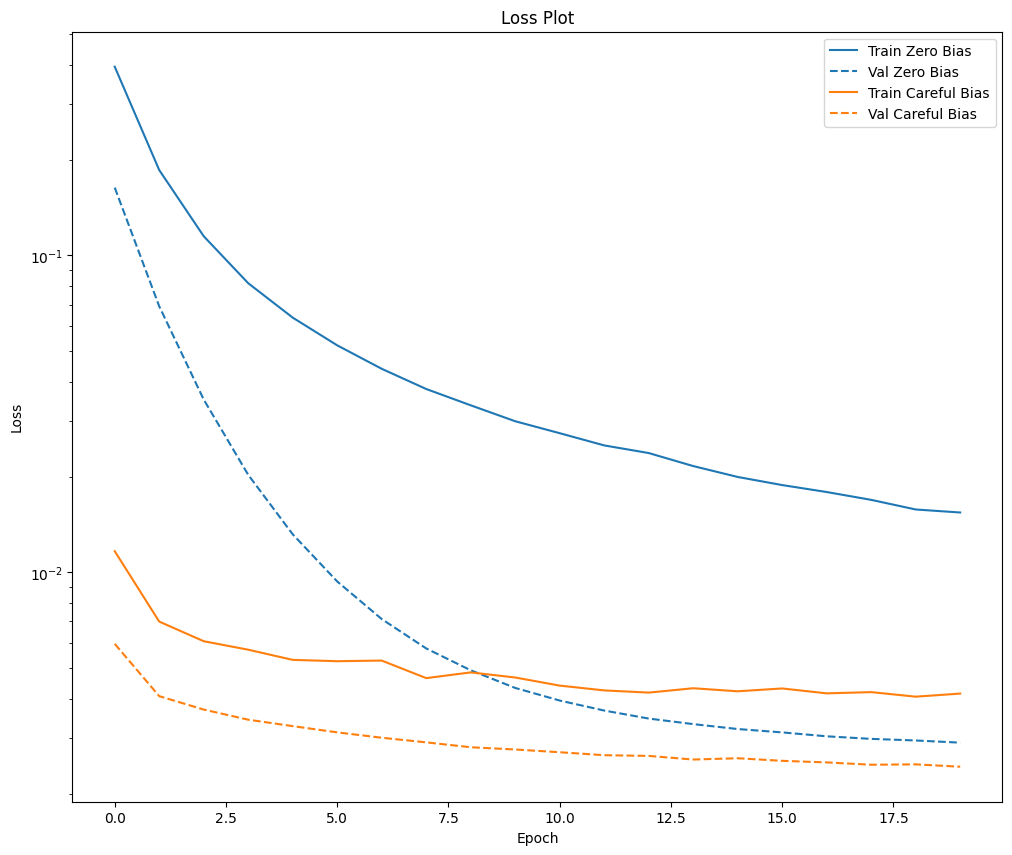

In [23]:
#Plotting the log loss of the models to see if the bias helped.
loss_plotter(zero_bias_history, "Zero Bias", 0)
loss_plotter(careful_bias_history, "Careful Bias", 1)

Training the model.

In [24]:
# Baseline model with initial weights.
model = model_maker()
model.load_weights(initial_weights)
baseline_history = model.fit(train_features, train_labels, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(val_features, val_labels), callbacks=[early_stopping], verbose=1)

Epoch 1/100
90/90 [==============================] - 2s 10ms/step - loss: 0.0119 - cross entropy: 0.0100 - Brier score: 0.0014 - binary accuracy: 0.9986 - precision: 0.8241 - recall: 0.2253 - tp: 89.0000 - tn: 227431.0000 - fp: 19.0000 - fn: 306.0000 - auc: 0.7412 - prc: 0.2995 - val_loss: 0.0059 - val_cross entropy: 0.0059 - val_Brier score: 0.0011 - val_binary accuracy: 0.9987 - val_precision: 1.0000 - val_recall: 0.2055 - val_tp: 15.0000 - val_tn: 45496.0000 - val_fp: 0.0000e+00 - val_fn: 58.0000 - val_auc: 0.9097 - val_prc: 0.6645
Epoch 2/100
90/90 [==============================] - 0s 3ms/step - loss: 0.0073 - cross entropy: 0.0073 - Brier score: 0.0011 - binary accuracy: 0.9987 - precision: 0.8397 - recall: 0.3416 - tp: 110.0000 - tn: 181933.0000 - fp: 21.0000 - fn: 212.0000 - auc: 0.8647 - prc: 0.4954 - val_loss: 0.0042 - val_cross entropy: 0.0042 - val_Brier score: 8.7265e-04 - val_binary accuracy: 0.9989 - val_precision: 0.7838 - val_recall: 0.3973 - val_tp: 29.0000 - val_tn: 

In [25]:
# Method that plots the metrics of the model.
def plot_metrics(history):
    metrics = ['loss', 'prc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2,2, n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label="Train")
        plt.plot(history.epoch, history.history["val_"+metric], color=colors[0], label="Val", linestyle="--")
        plt.xlabel("Epoch")
        plt.ylabel(name)
        if metric == "loss":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "auc":
            plt.ylim([0.8, 1])
        else:
            plt.ylim([0, 1])

        plt.legend()

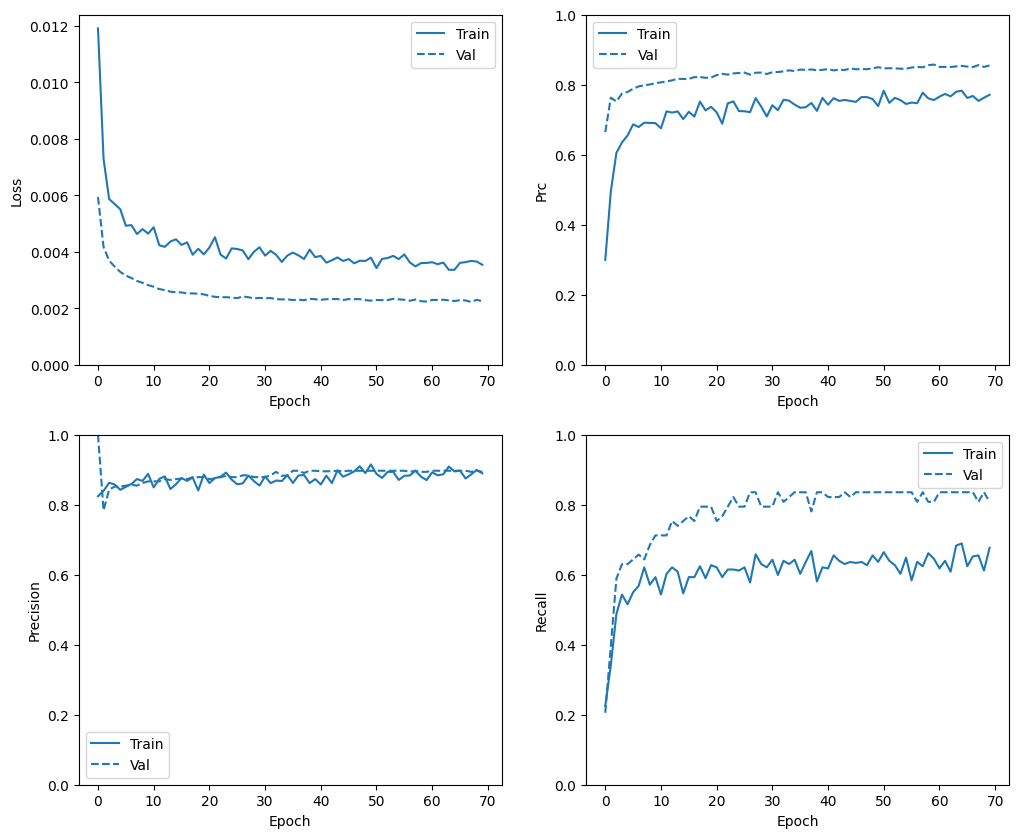

In [26]:
plot_metrics(baseline_history)

In [27]:
# Predictions on train and test features.
baseline_train_predictions = model.predict(train_features, batch_size=BATCH_SIZE, verbose=1)
baseline_test_predictions = model.predict(test_features, batch_size=BATCH_SIZE, verbose=1)

28/28 [==============================] - 0s 1ms/step


In [36]:
# Method that plots the confusion matrix of the model predictions.
def plot_confusion_matrix(labels, predictions, threshold=0.5):
    cm = confusion_matrix(labels, predictions > threshold)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion matrix @{:.2f}".format(threshold))
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")

loss :  0.0032273156102746725
cross entropy :  0.0032273156102746725
Brier score :  0.0005105400341562927
binary accuracy :  0.9993855357170105
precision :  0.887499988079071
recall :  0.7319587469100952
tp :  71.0
tn :  56856.0
fp :  9.0
fn :  26.0
auc :  0.9171698689460754
prc :  0.8060500621795654



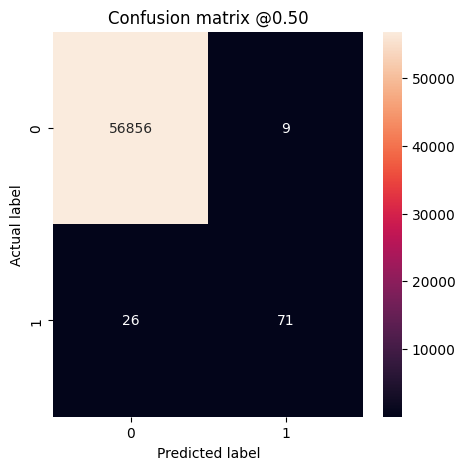

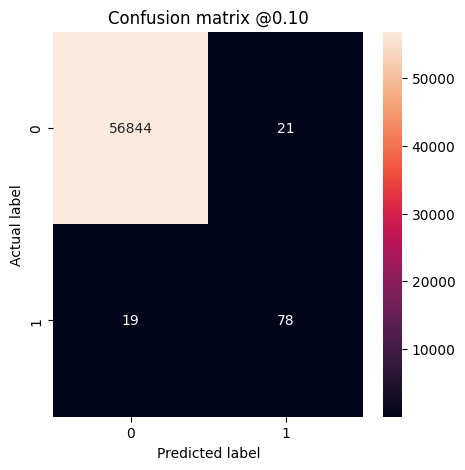

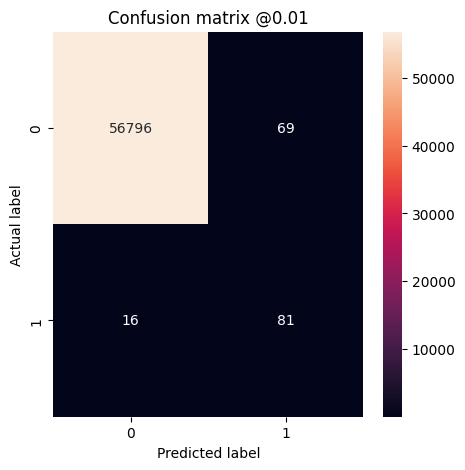

In [38]:
# Evaluating test data on the baseline model.
baseline_results = model.evaluate(test_features, test_labels, verbose=0, batch_size=BATCH_SIZE)

# Printing the baseline results.
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

# Plotting the baseline confusion matrix of the test data with different thresholds.
plot_confusion_matrix(test_labels, baseline_test_predictions) # Default threshold of 0.5
plot_confusion_matrix(test_labels, baseline_test_predictions, threshold=0.1)
plot_confusion_matrix(test_labels, baseline_test_predictions, threshold=0.01)

In [40]:
#Method that plots the ROC curve of the model.
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel("False Positives [%]")
    plt.ylabel("True Positives [%]")
    plt.xlim([-0.5,20])
    plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

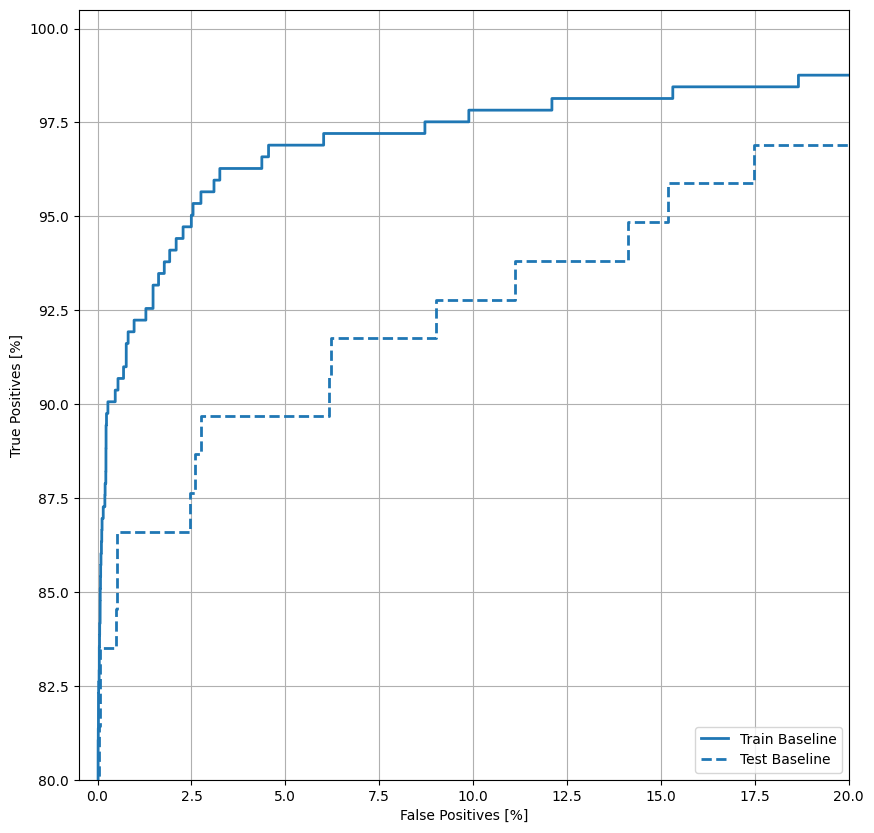

In [41]:
#Plotting the ROC-curves to see the performance of the model with different output thresholds.
plot_roc("Train Baseline", train_labels, baseline_train_predictions, color=colors[0])
plot_roc("Test Baseline", test_labels, baseline_test_predictions, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [42]:
# Method that plots the precision recall curve of the model.
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

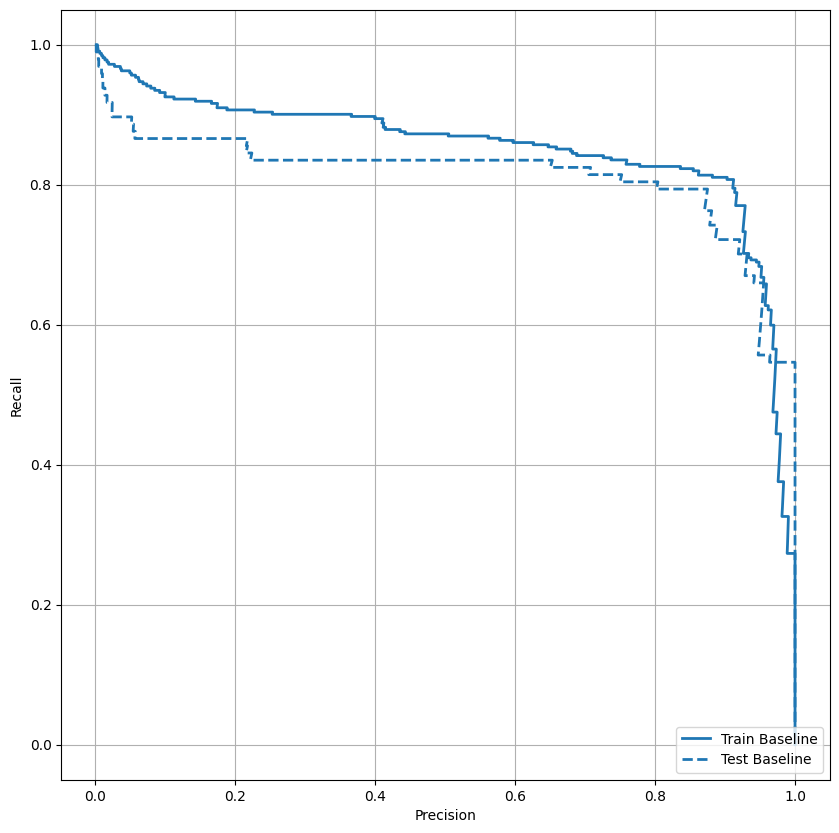

In [43]:
plot_prc("Train Baseline", train_labels, baseline_train_predictions, color=colors[0])
plot_prc("Test Baseline", test_labels, baseline_test_predictions, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

Training the model with the class weights.

In [44]:
#Calculating the class weights.
total = neg + pos
class_weight_0 = (1 / neg) * (total) / 2.0
class_weight_1 = (1 / pos) * (total) / 2.0

class_weight = {0: class_weight_0, 1: class_weight_1}

print('Negative Class Weight: {:.2f}'.format(class_weight_0))
print('Positive Class Weight: {:.2f}'.format(class_weight_1))

Negative Class Weight: 0.50
Positive Class Weight: 289.44


In [45]:
weighted_model = model_maker()
weighted_model.load_weights(initial_weights)
weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    class_weight=class_weight)

Epoch 1/100
90/90 [==============================] - 1s 7ms/step - loss: 2.6202 - cross entropy: 0.0106 - Brier score: 0.0015 - binary accuracy: 0.9984 - precision: 0.6395 - recall: 0.2625 - tp: 110.0000 - tn: 238757.0000 - fp: 62.0000 - fn: 309.0000 - auc: 0.7551 - prc: 0.2971 - val_loss: 0.0064 - val_cross entropy: 0.0064 - val_Brier score: 0.0010 - val_binary accuracy: 0.9988 - val_precision: 0.8846 - val_recall: 0.3151 - val_tp: 23.0000 - val_tn: 45493.0000 - val_fp: 3.0000 - val_fn: 50.0000 - val_auc: 0.9263 - val_prc: 0.5731
Epoch 2/100
90/90 [==============================] - 0s 3ms/step - loss: 1.1695 - cross entropy: 0.0117 - Brier score: 0.0017 - binary accuracy: 0.9982 - precision: 0.5033 - recall: 0.4689 - tp: 151.0000 - tn: 181805.0000 - fp: 149.0000 - fn: 171.0000 - auc: 0.8696 - prc: 0.4220 - val_loss: 0.0067 - val_cross entropy: 0.0067 - val_Brier score: 6.6548e-04 - val_binary accuracy: 0.9993 - val_precision: 0.8387 - val_recall: 0.7123 - val_tp: 52.0000 - val_tn: 454

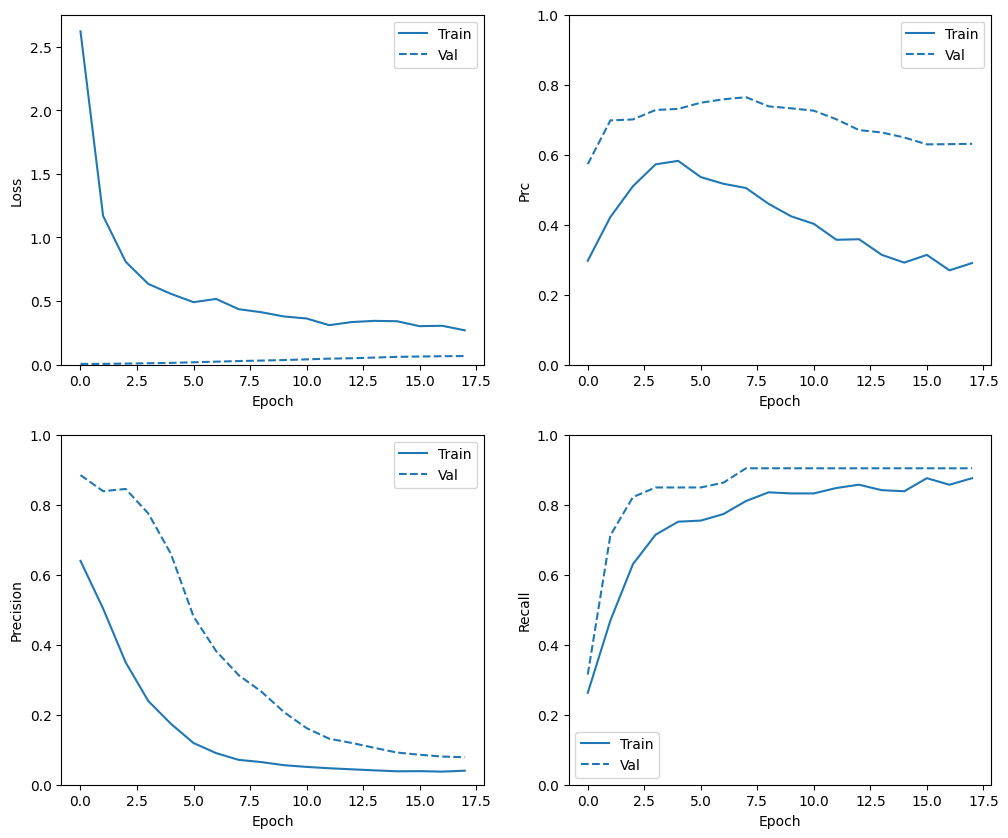

In [46]:
plot_metrics(weighted_history)

In [47]:
weighted_train_predictions = weighted_model.predict(train_features, batch_size=BATCH_SIZE, verbose=1)
weighted_test_predictions = weighted_model.predict(test_features, batch_size=BATCH_SIZE, verbose=1)

28/28 [==============================] - 0s 817us/step


loss :  0.03046366386115551
cross entropy :  0.03046366386115551
Brier score :  0.004085354506969452
binary accuracy :  0.996366024017334
precision :  0.29629629850387573
recall :  0.8247422575950623
tp :  80.0
tn :  56675.0
fp :  190.0
fn :  17.0
auc :  0.9476507306098938
prc :  0.659267008304596



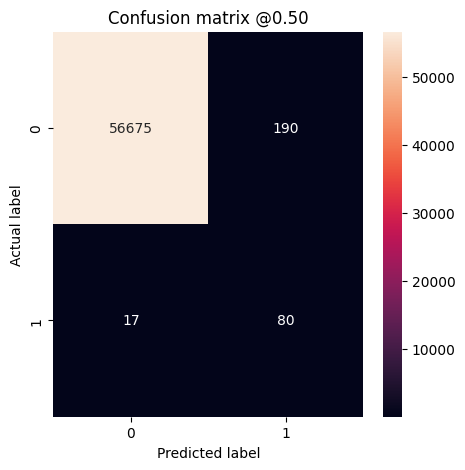

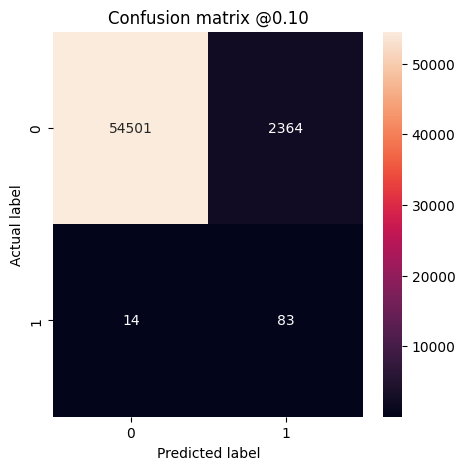

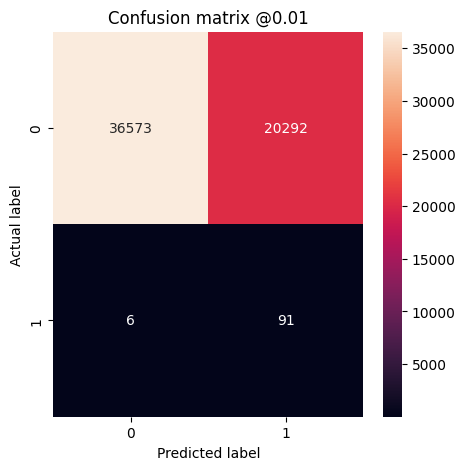

In [48]:
weighted_results = weighted_model.evaluate(test_features, test_labels, verbose=0, batch_size=BATCH_SIZE)

for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_confusion_matrix(test_labels, weighted_test_predictions)
plot_confusion_matrix(test_labels, weighted_test_predictions, threshold=0.1)
plot_confusion_matrix(test_labels, weighted_test_predictions, threshold=0.01)

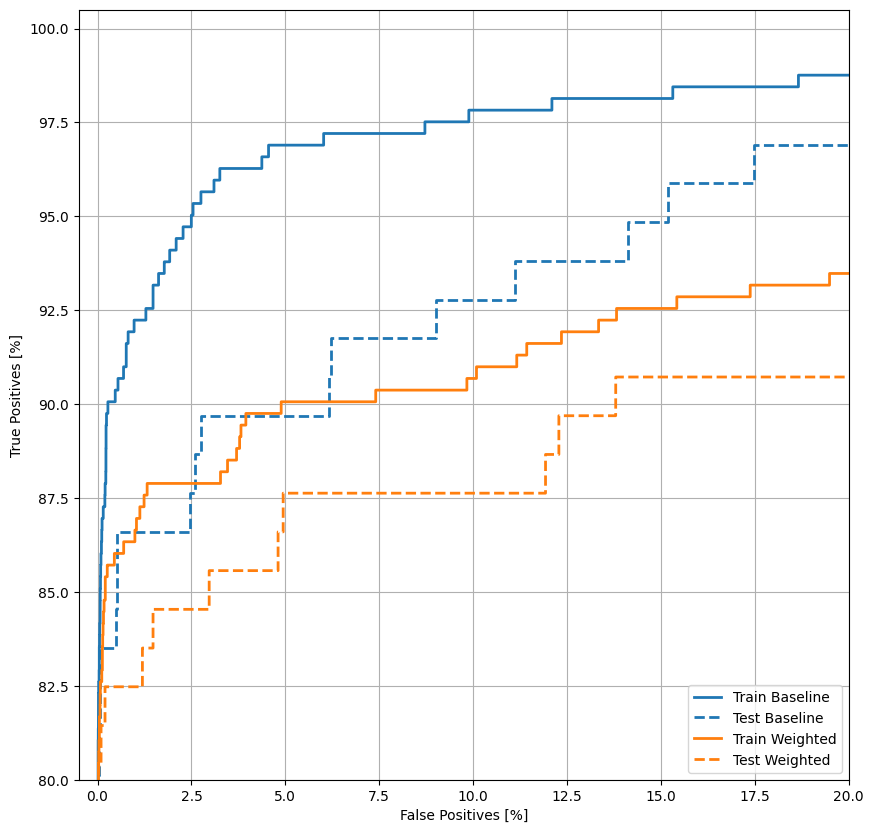

In [49]:
#Comparing the baseline model to the weighted model on ROC curve.
plot_roc("Train Baseline", train_labels, baseline_train_predictions, color=colors[0])
plot_roc("Test Baseline", test_labels, baseline_test_predictions, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, weighted_train_predictions, color=colors[1])
plot_roc("Test Weighted", test_labels, weighted_test_predictions, color=colors[1], linestyle='--')

plt.legend(loc='lower right');

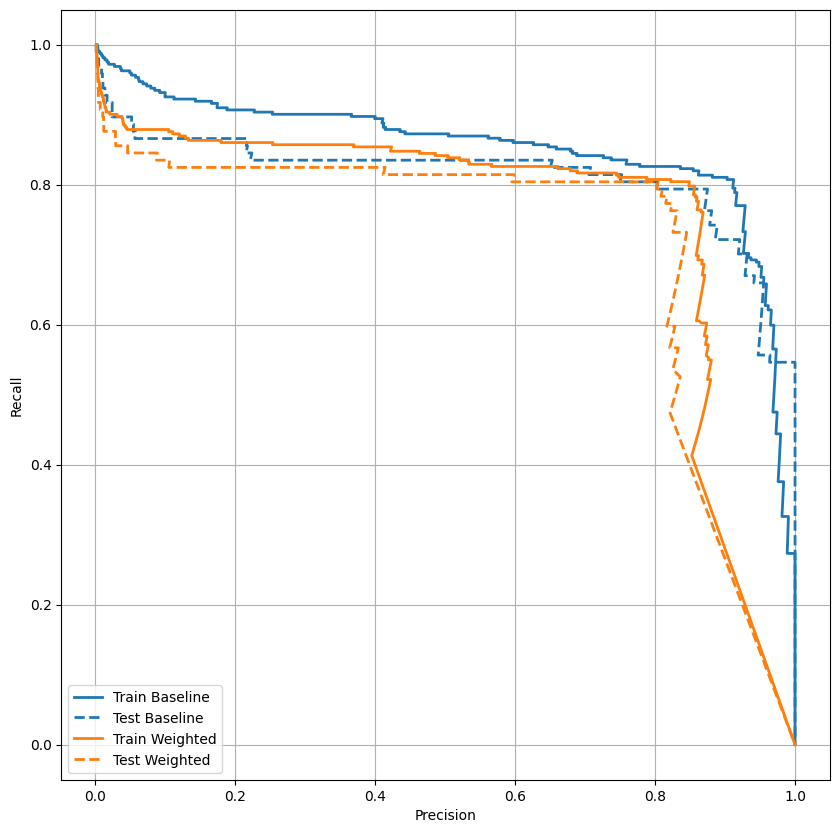

In [50]:
#Comparing the baseline model to the weighted model on the Precision-Recall Curve.
plot_prc("Train Baseline", train_labels, baseline_train_predictions, color=colors[0])
plot_prc("Test Baseline", test_labels, baseline_test_predictions, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, weighted_train_predictions, color=colors[1])
plot_prc("Test Weighted", test_labels, weighted_test_predictions, color=colors[1], linestyle='--')

plt.legend(loc='lower left');

Training the model with oversampled data.

In [51]:
# Using numpy to oversample the minority class.

# Positive and negative features and labels.
positive_features = train_features[bool_train_labels]
negative_features = train_features[~bool_train_labels]

positive_labels = train_labels[bool_train_labels]
negative_labels = train_labels[~bool_train_labels]

indices = np.arange(len(positive_features))
choices = np.random.choice(indices, len(negative_features))

res_positive_features = positive_features[choices]
res_positive_labels = positive_labels[choices]

# Combining resampled positive features and labels with the negative features and labels.
resampled_features = np.concatenate([res_positive_features, negative_features], axis=0)
resampled_labels = np.concatenate([res_positive_labels, negative_labels], axis=0)

# Shuffling the data.
order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

In [52]:
resampled_model = model_maker()
resampled_model.load_weights(initial_weights)

# Reseting the bias to zero
output_layer = resampled_model.layers[-1].bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_features,
    resampled_labels,
    batch_size=BATCH_SIZE, 
    steps_per_epoch=20, # Added steps_per_epoch=20 and changed epochs= EPOCHS to 10*EPOCHS to avoid overfitting.  
    epochs=10*EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/1000
20/20 [==============================] - 2s 24ms/step - loss: 1.1659 - cross entropy: 0.5054 - Brier score: 0.1368 - binary accuracy: 0.8164 - precision: 0.5851 - recall: 0.4484 - tp: 9273.0000 - tn: 70668.0000 - fp: 6575.0000 - fn: 11406.0000 - auc: 0.8033 - prc: 0.5974 - val_loss: 0.5254 - val_cross entropy: 0.5254 - val_Brier score: 0.1739 - val_binary accuracy: 0.7560 - val_precision: 0.0046 - val_recall: 0.6986 - val_tp: 51.0000 - val_tn: 34401.0000 - val_fp: 11095.0000 - val_fn: 22.0000 - val_auc: 0.7889 - val_prc: 0.1249
Epoch 2/1000
20/20 [==============================] - 0s 6ms/step - loss: 0.7175 - cross entropy: 0.7175 - Brier score: 0.2266 - binary accuracy: 0.6748 - precision: 0.6785 - recall: 0.6650 - tp: 13627.0000 - tn: 14013.0000 - fp: 6456.0000 - fn: 6864.0000 - auc: 0.7198 - prc: 0.7913 - val_loss: 0.4994 - val_cross entropy: 0.4994 - val_Brier score: 0.1630 - val_binary accuracy: 0.7770 - val_precision: 0.0062 - val_recall: 0.8630 - val_tp: 63.0000 - v

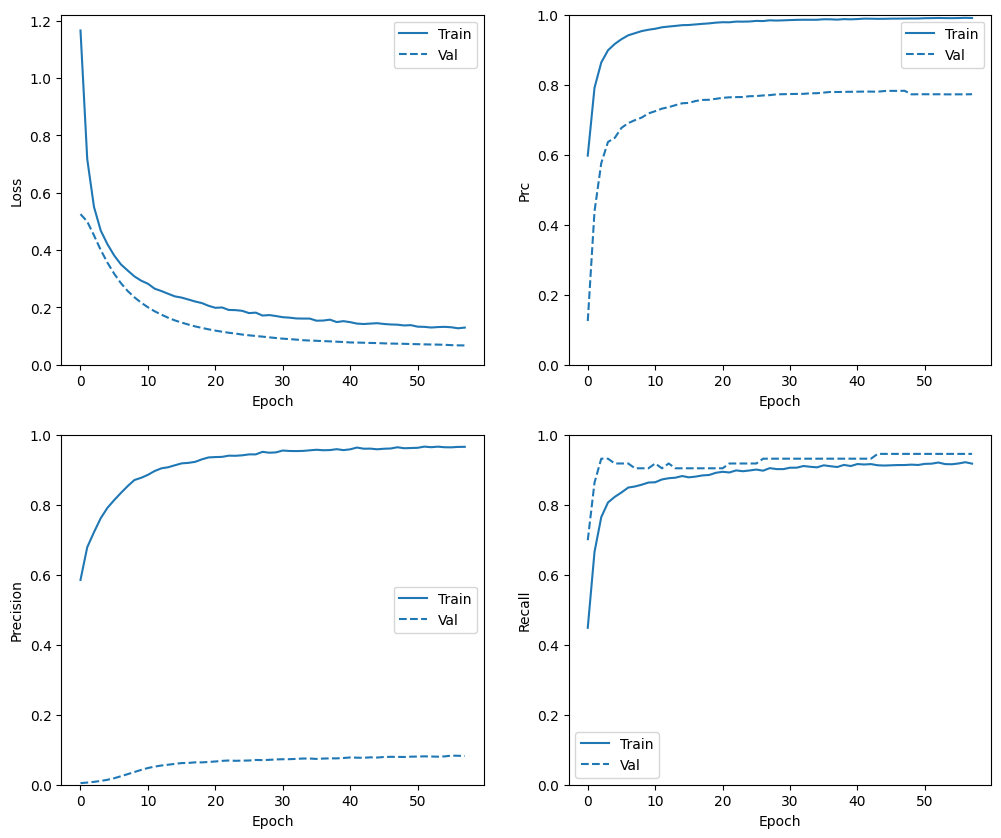

In [53]:
plot_metrics(resampled_history)

In [54]:
resampled_train_predictions = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
resampled_test_predictions = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

28/28 [==============================] - 0s 852us/step


loss :  0.07236147671937943
cross entropy :  0.07236147671937943
Brier score :  0.015750618651509285
binary accuracy :  0.9835153222084045
precision :  0.08316832035779953
recall :  0.8659793734550476
tp :  84.0
tn :  55939.0
fp :  926.0
fn :  13.0
auc :  0.972659170627594
prc :  0.6787612438201904



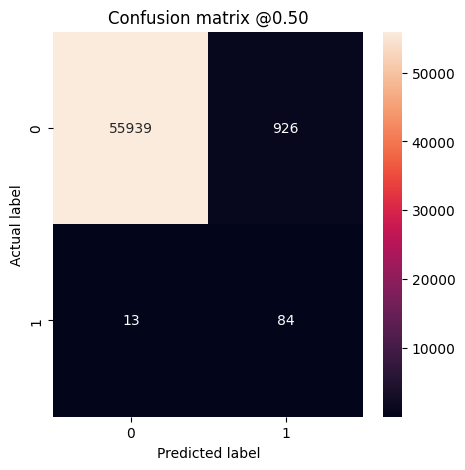

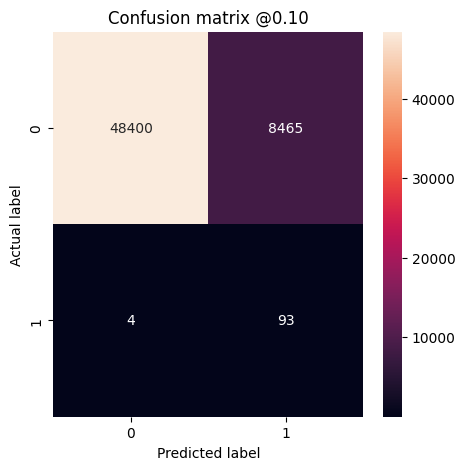

In [58]:
resampled_results = resampled_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)

for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_confusion_matrix(test_labels, resampled_test_predictions)
plot_confusion_matrix(test_labels, resampled_test_predictions, threshold=0.1)

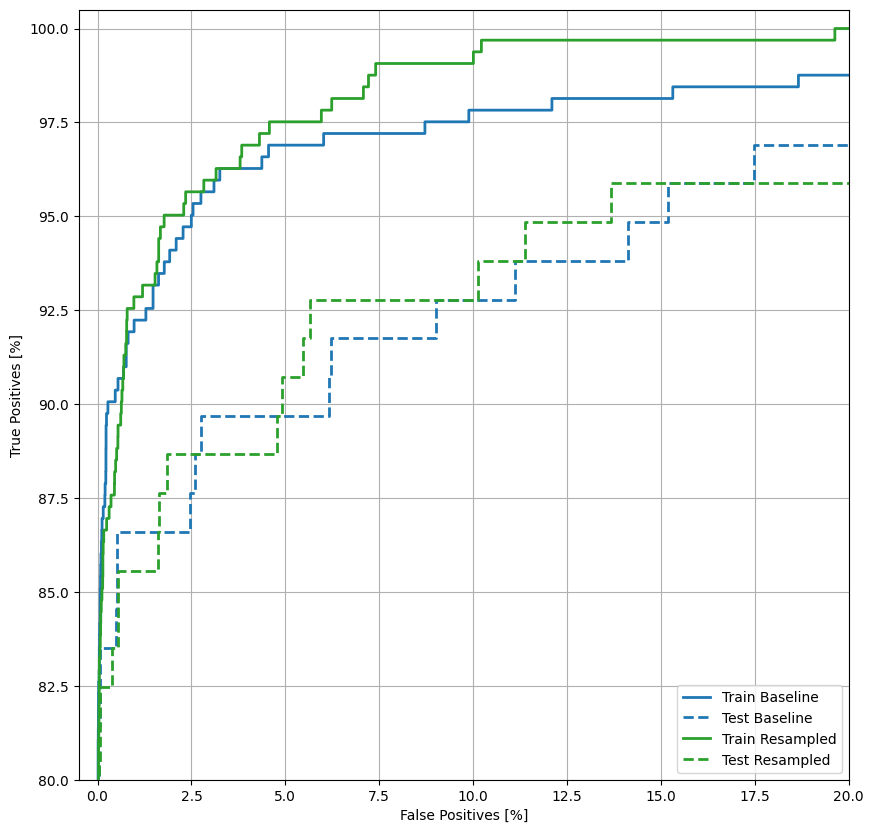

In [56]:
#Comparing the baseline and resampled model on Roc curve.
plot_roc("Train Baseline", train_labels, baseline_train_predictions, color=colors[0])
plot_roc("Test Baseline", test_labels, baseline_test_predictions, color=colors[0], linestyle='--')

plot_roc("Train Resampled", train_labels, resampled_train_predictions,  color=colors[2])
plot_roc("Test Resampled", test_labels, resampled_test_predictions,  color=colors[2], linestyle='--')

plt.legend(loc='lower right')

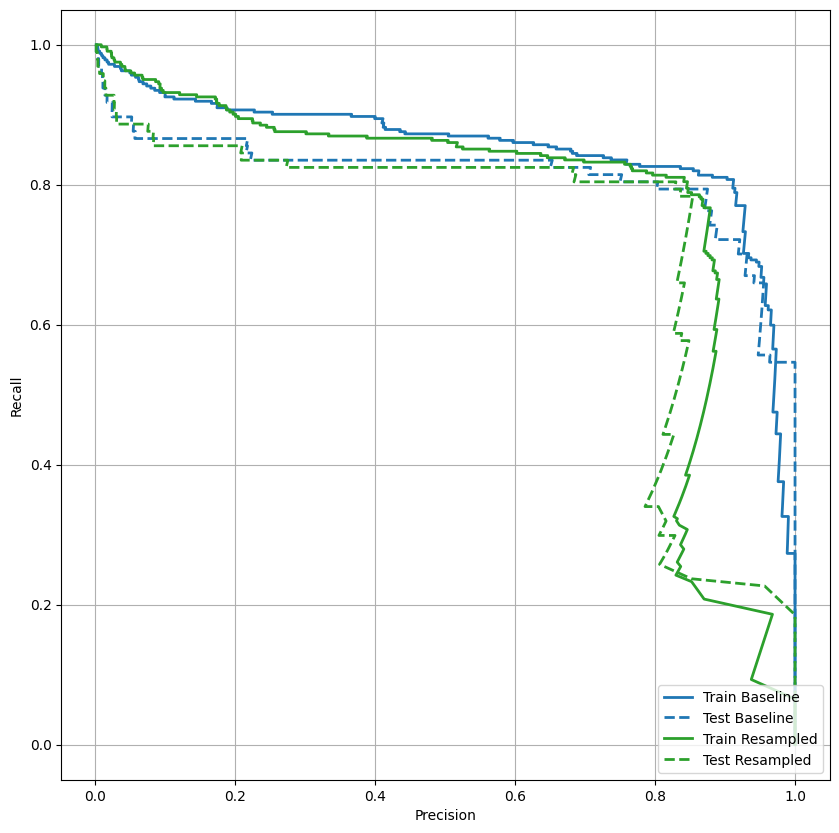

In [57]:
#Comparing the baseline model to the resampled model on the Precision-Recall Curve.
plot_prc("Train Baseline", train_labels, baseline_train_predictions, color=colors[0])
plot_prc("Test Baseline", test_labels, baseline_test_predictions, color=colors[0], linestyle='--')

plot_prc("Train Resampled", train_labels, resampled_train_predictions, color=colors[2])
plot_prc("Test Resampled", test_labels, resampled_test_predictions, color=colors[2], linestyle='--')

plt.legend(loc='lower right');